# Cleaning and drop features

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import LabelEncoder


In [2]:
df = pd.read_csv('../data/data_cleaned.csv', sep=',')

# encode target variable: 0: dropout, 1: enrolled, 2: graduated
le = LabelEncoder()
df['Target_encoded'] = le.fit_transform(df['Target'])

# Drop 'Target' variable
df.drop('Target', axis = 1, inplace = True)

# Change data types of columns that should be categorical
col = ['Marital_status', 'Application_mode', 'Course', 'Previous_qualification',
       'Mother_qualification', 'Father_qualification', 'Mother_occupation',
       'Father_occupation','Target_encoded']

df[col] = df[col].astype('category')


stud_selected = df.drop(['Nationality', 'International', 'Educational_special_needs','Marital_status', 'Inflation_rate'], axis = 1)  
stud_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 32 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   Application_mode                              4424 non-null   category
 1   Application_order                             4424 non-null   int64   
 2   Course                                        4424 non-null   category
 3   Daytime/evening_attendance                    4424 non-null   int64   
 4   Previous_qualification                        4424 non-null   category
 5   Previous_qualification_grade                  4424 non-null   float64 
 6   Mother_qualification                          4424 non-null   category
 7   Father_qualification                          4424 non-null   category
 8   Mother_occupation                             4424 non-null   category
 9   Father_occupation                             4424 n


| **Prestazione media**    Compatta le due note in un’unica metrica di qualità.     
                                                          
| **Efficienza**          Normalizzi per il numero di unità: evita che chi segue più corsi sembri “peggiore” solo perché ha più valutazioni. 

| **Trend / miglioramento** Cattura se lo studente recupera o peggiora; spesso è più predittivo del valore assoluto.    
                       
| **Carico di lavoro**  Indicatori di impegno complessivo, utili per dropout-risk.                                                         

| **Flag di rischio precoce**    Variabile binaria che riassume il primo semestre.                                                                  


quando due set di variabili sono altamente correlati perché misurano lo stesso concetto a momenti diversi, trasforma le seconde in segnali di progresso (differenze, rapporti, medie); spesso è l’andamento, non il valore assoluto, a distinguere chi si laurea da chi abbandona.

0 → 1: quanto lo studente si presenta davvero agli esami.

Delta > 0: migliora l’impegno; <br>
Delta < 0: cala (segnale di rischio).

# Features imbalanced

In [3]:
cat_cols = stud_selected.select_dtypes(include='category')

# Check the number of unique values in each categorical column
for col in cat_cols.columns:
    n_val = stud_selected[col].nunique()
    print(f"{col}: {n_val} unique values")

Marital_status: 6 unique values
Application_mode: 18 unique values
Course: 17 unique values
Previous_qualification: 17 unique values
Mother_qualification: 29 unique values
Father_qualification: 34 unique values
Mother_occupation: 32 unique values
Father_occupation: 46 unique values
Target_encoded: 3 unique values


In [4]:
def imbalance_report(df: pd.DataFrame, cat_columns, rare_thresh=0.01):
    """
    Return a DataFrame with imbalance metrics for each categorical column.
    - dominant_share: % of the most frequent category
    - rare_share    : total % of categories below `rare_thresh`
    - n_categories  : number of distinct categories
    """
    rows = []
    for col in cat_columns:
        freqs = df[col].value_counts(normalize=True, dropna=False)
        dominant_share = freqs.iloc[0]
        rare_share = freqs[freqs < rare_thresh].sum()
        rows.append({
            "feature": col,
            "dominant_share": dominant_share,
            "rare_share": rare_share,
            "n_categories": len(freqs)
        })
    return pd.DataFrame(rows).set_index("feature")           \
                             .sort_values("dominant_share", ascending=False)

imbalance_df = imbalance_report(stud_selected, cat_cols, rare_thresh=0.01)
print(imbalance_df.head(16))    # show the most skewed first


                        dominant_share  rare_share  n_categories
feature                                                         
Marital_status                0.885850    0.007911             6
Previous_qualification        0.840190    0.035036            17
Target_encoded                0.499322    0.000000             3
Application_mode              0.386076    0.030515            18
Mother_occupation             0.356465    0.034358            32
Father_qualification          0.273282    0.040461            34
Mother_qualification          0.241637    0.029611            29
Father_occupation             0.228300    0.025316            46
Course                        0.173146    0.002712            17


| `dominant_share ≥ 0.85` | Variabile dominata da un’unica modalità → alto rischio che le altre colonne “valgano zero”. 

| `rare_share ≥ 0.20`     | Molte modalità con frequenza < 1 % → sparsità elevata in one-hot, possibile over-fitting. 
  
| `n_categories ≫ 50`     | Cardinalità alta, anche se distribuzione non estrema.                                       


**COLLAPSE RARE LEVELS**

In [5]:
THRESH = 0.01          # share below which a level is considered "rare" (1 %)

cat_cols = []
for col in stud_selected.columns:
    if stud_selected[col].dtype.name in ["category"]:
        cat_cols.append(col)

print(f"Categorical columns detected ({len(cat_cols)}): {cat_cols}")

# -------------------------------------------------------------------
# 2) Collapse rare levels into the new code "0"
# -------------------------------------------------------------------
for col in cat_cols:
    # Ensure the column is of pandas 'category' dtype
    stud_selected[col] = stud_selected[col].astype("category")

    # Share of each level (NaNs kept separate)
    freqs = stud_selected[col].value_counts(normalize=True, dropna=False)
    rare_levels = freqs[freqs < THRESH].index

    # Skip columns with no rare levels
    if rare_levels.empty:
        continue

    # Add the new category code (0) if it doesn't exist yet
    if 0 not in stud_selected[col].cat.categories:
        stud_selected[col] = stud_selected[col].cat.add_categories([0])

    # Replace every rare level with 0
    stud_selected[col] = stud_selected[col].where(~stud_selected[col].isin(rare_levels), 0)

    # Optional: drop categories that disappeared after the replacement
    stud_selected[col] = stud_selected[col].cat.remove_unused_categories()

    print(f"Column '{col}': collapsed {len(rare_levels)} rare level(s) into 0")

# -------------------------------------------------------------------
# 3) (Optional) quick sanity-check
# -------------------------------------------------------------------
for col in cat_cols[:5]:   # inspect first 5 categorical columns
    print("\n", stud_selected[col].value_counts(normalize=True).head())


Categorical columns detected (9): ['Marital_status', 'Application_mode', 'Course', 'Previous_qualification', 'Mother_qualification', 'Father_qualification', 'Mother_occupation', 'Father_occupation', 'Target_encoded']
Column 'Marital_status': collapsed 3 rare level(s) into 0
Column 'Application_mode': collapsed 9 rare level(s) into 0
Column 'Course': collapsed 1 rare level(s) into 0
Column 'Previous_qualification': collapsed 12 rare level(s) into 0
Column 'Mother_qualification': collapsed 21 rare level(s) into 0
Column 'Father_qualification': collapsed 27 rare level(s) into 0
Column 'Mother_occupation': collapsed 22 rare level(s) into 0
Column 'Father_occupation': collapsed 34 rare level(s) into 0

 Marital_status
1    0.885850
2    0.085669
4    0.020570
0    0.007911
Name: proportion, dtype: float64

 Application_mode
1     0.386076
17    0.197107
39    0.177441
43    0.070524
44    0.048146
Name: proportion, dtype: float64

 Course
9500    0.173146
9147    0.085895
9238    0.080244
9

In [6]:
cat_columns = stud_selected.select_dtypes(include='category')

# Check the number of unique values in each categorical column
for col in cat_columns.columns:
    n_val = stud_selected[col].nunique()
    print(f"{col}: {n_val} unique values")

Marital_status: 4 unique values
Application_mode: 10 unique values
Course: 17 unique values
Previous_qualification: 6 unique values
Mother_qualification: 9 unique values
Father_qualification: 8 unique values
Mother_occupation: 10 unique values
Father_occupation: 12 unique values
Target_encoded: 3 unique values


# Data Splitting

X_train shape: (3539, 31)
X_test shape: (885, 31)
y_train shape: (3539,)
y_test shape: (885,)


C:\Users\Martina\AppData\Local\Temp\ipykernel_6988\3702010728.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.assign(Percentage=100 * x['Count'] / x['Count'].sum()))


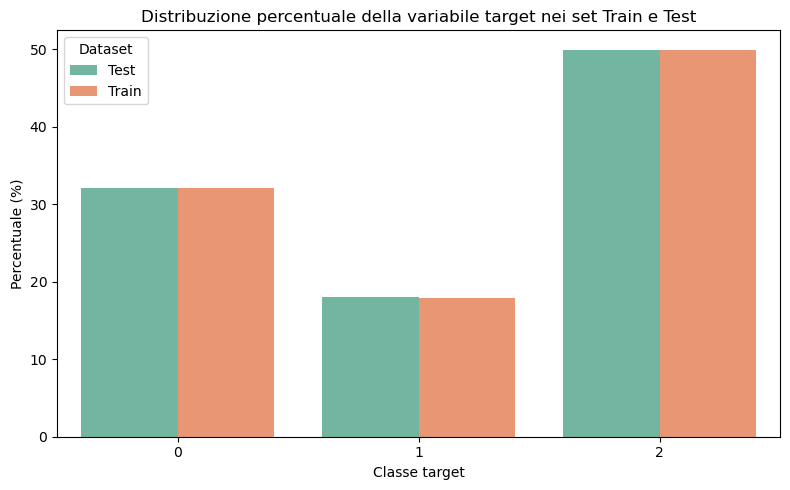

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight

X = stud_selected.drop('Target_encoded', axis=1)  
y = stud_selected['Target_encoded']  

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# === Visualizzazione distribuzione target ===
# Ricrea il DataFrame con etichette
dist_df = pd.DataFrame({
    'Set': ['Train'] * len(y_train) + ['Test'] * len(y_test),
    'Target': pd.concat([y_train, y_test])
})

# Calcola le percentuali
percent_df = (
    dist_df.value_counts(['Set', 'Target'])
    .reset_index(name='Count')
    .groupby('Set')
    .apply(lambda x: x.assign(Percentage=100 * x['Count'] / x['Count'].sum()))
    .reset_index(drop=True)
)

# Plot percentuale
plt.figure(figsize=(8, 5))
sns.barplot(data=percent_df, x='Target', y='Percentage', hue='Set', palette='Set2')
plt.title('Distribuzione percentuale della variabile target nei set Train e Test')
plt.xlabel('Classe target')
plt.ylabel('Percentuale (%)')
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

In [4]:
from collections import Counter

print(Counter(y_train))

Counter({2: 1767, 0: 1137, 1: 635})


# Model comparison

1- FeaturesTrasformer (create new features)

2 - preprocessing (Standard Scaler, OneHot)

3- SelectPercentile (percentile=75, filtro per evitare overfitting)

4- RFECV / selectFromModel(alg tree-based)

5- SMOTE

5- model 

Provare con e senza feature selection

Decidere le metriche da valutare e stampare 

| Metrica               | Quando usarla                                   |
| --------------------- | ----------------------------------------------- |
| **Accuracy**          | Classi bilanciate, visione generale             |
| **F1-macro/Precision/Recall**          | Performance uguale su tutte le classi       |
| **F1-weighted/Precision/Recall**       | Se ti interessa anche il peso delle classi      |
| **Balanced Accuracy** | Quando ci sono classi sbilanciate         |
| **Confusion Matrix**  | Per capire dove sbaglia il modello          |
| **ROC AUC**           | Se lavori con probabilità e vuoi valutare curve |


precision_macro = media(precision per ciascuna classe) <br>
recall_macro = media(recall per ciascuna classe) <br>
f1_macro = media(F1 per ciascuna classe) 

precision_weighted = somma(precision_i * supporto_i) / totale


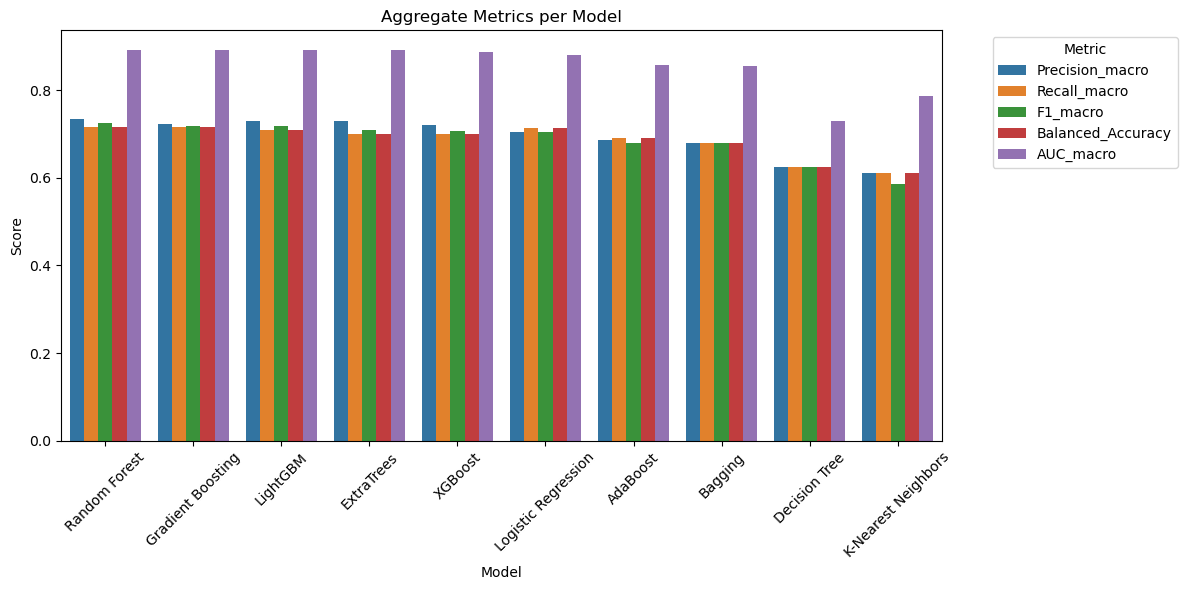

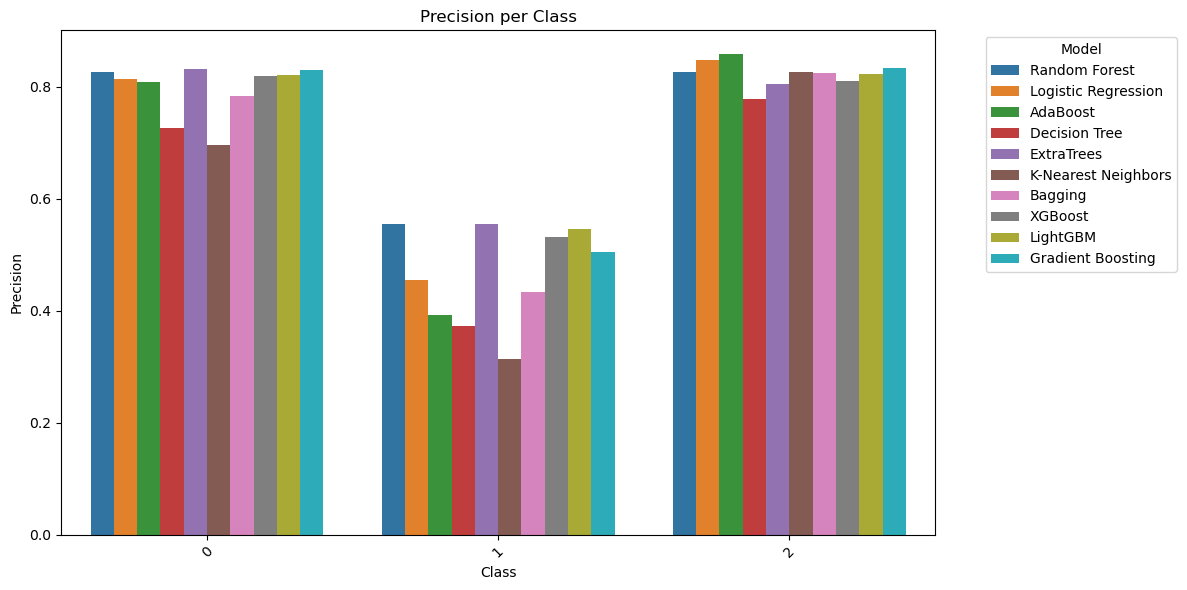

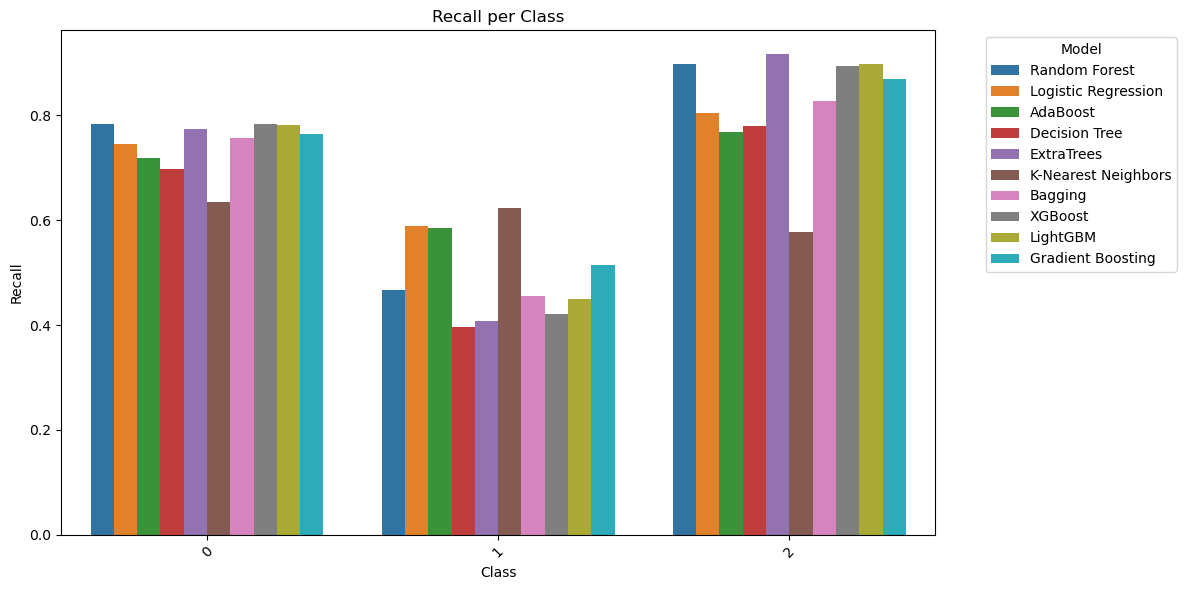

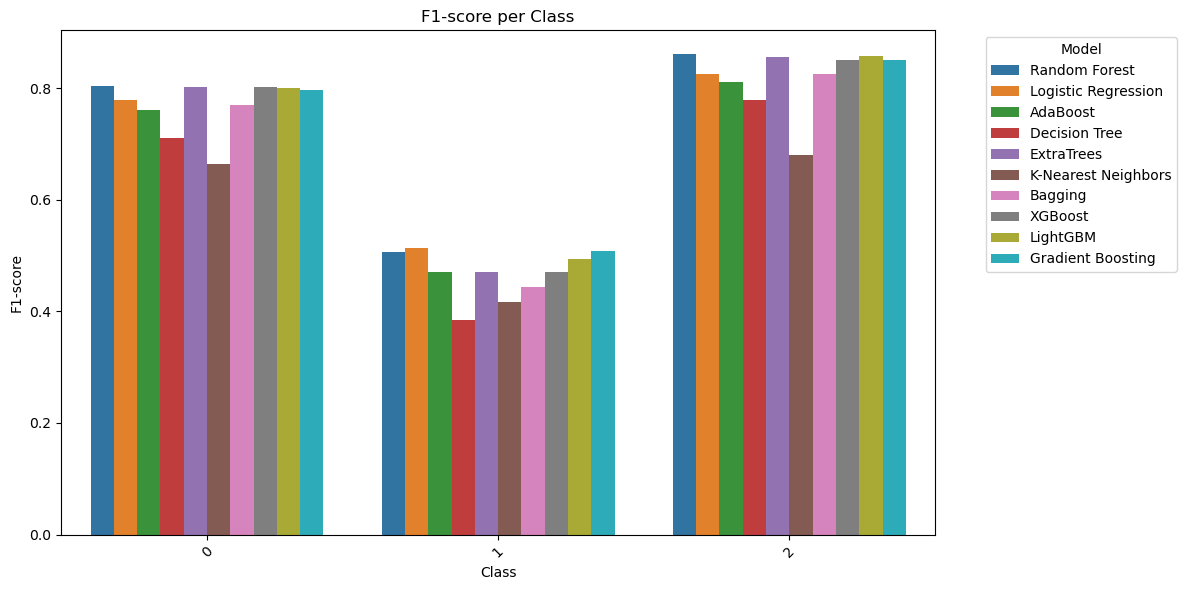

In [5]:

import matplotlib.pyplot as plt
import seaborn as sns

# Seleziona le metriche da visualizzare
metrics = ['Precision_macro', 'Recall_macro', 'F1_macro', 'Balanced_Accuracy','AUC_macro']
results_melted = results_df.melt(id_vars='Model', value_vars=metrics, var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(data=results_melted, x='Model', y='Score', hue='Metric')
plt.xticks(rotation=45)
plt.title('Aggregate Metrics per Model')
plt.ylabel('Score')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Seleziona le metriche per classe
class_metrics = ['Precision', 'Recall', 'F1-score']
for metric in class_metrics:
    plt.figure(figsize=(12, 6))
    sns.barplot(data=detailed_df, x='Class', y=metric, hue='Model')
    plt.title(f'{metric} per Class')
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


La classe "Enrolled" rappresenta studenti ancora iscritti e può includere:

- studenti regolari al secondo anno

- studenti fuori corso

- situazioni sospese/ambigue

Questa eterogeneità induce rumore: il modello fatica a trovare pattern coerenti.

# Permutation Importance class enrolled

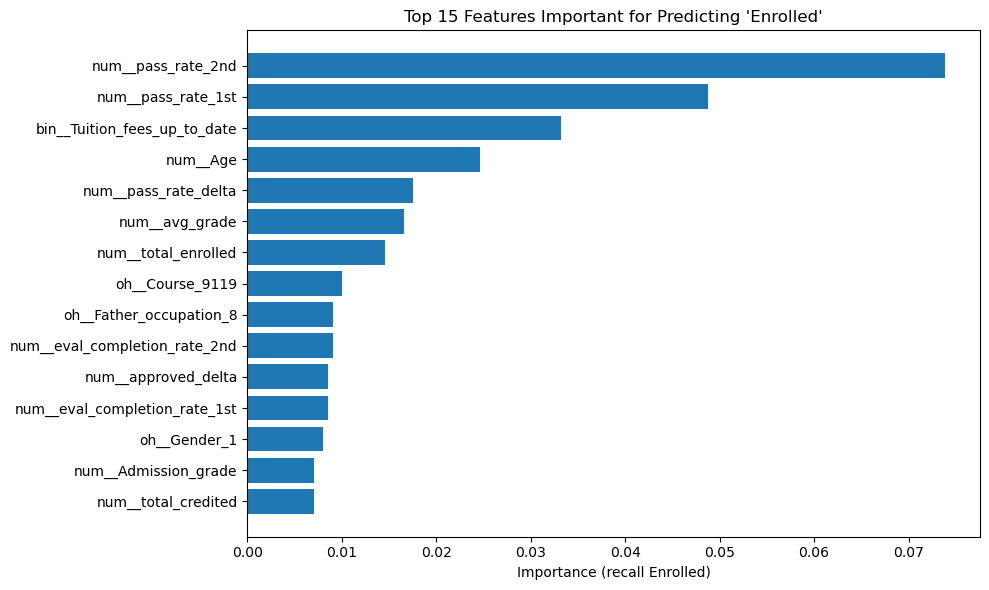

In [ ]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, recall_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def recall_enrolled(y_true, y_pred):
   return recall_score(y_true, y_pred, average=None, labels=[0, 1, 2])[1]

# 1. Trasforma X_test completamente (feature engineering + preprocessing)
X_test_fe = rf_pipeline.named_steps['feature_transformer'].transform(X_test)
X_test_processed = rf_pipeline.named_steps['preprocessing'].transform(X_test_fe)

if hasattr(X_test_processed, "toarray"):
    X_test_processed = X_test_processed.toarray()

# 2. Estrai modello dalla rf_pipeline
model = rf_pipeline.named_steps['model']

# 3. Ottieni nomi delle feature trasformate
feature_names = rf_pipeline.named_steps['preprocessing'].get_feature_names_out()

# 4. Calcola permutation importance SUL MODELLO FINALE (fuori dalla rf_pipeline)
result = permutation_importance(
    model, 
    X_test_processed, y_test,
    scoring=make_scorer(recall_enrolled),
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# 5. Crea DataFrame ordinato
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

# 6. Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:15][::-1], importance_df['Importance'][:15][::-1])
plt.xlabel("Importance (recall Enrolled)")
plt.title("Top 15 Features Important for Predicting 'Enrolled'")
plt.tight_layout()
plt.show()


## Analisi degli errori di classificazione per capire perché fallisce il modello

In [46]:
# Predizioni finali dal tuo modello Random Forest
y_pred = rf_pipeline.predict(X_test)


# Crea un DataFrame con predizioni e vero target
df_eval = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred
})

# Aggiungi l'input pre-elaborato per SHAP
df_shap = X_shap.copy()
df_shap['y_true'] = y_test
df_shap['y_pred'] = y_pred

# Falsi negativi: erano Enrolled ma classificati come altro
false_negatives = df_shap[(df_shap['y_true'] == 1) & (df_shap['y_pred'] != 1)]

# Falsi positivi: classificati come Enrolled ma non lo sono
false_positives = df_shap[(df_shap['y_true'] != 1) & (df_shap['y_pred'] == 1)]

print(f"False Negatives (Enrolled not predicted): {false_negatives.shape[0]}")
print(f"False Positives (Wrongly predicted as Enrolled): {false_positives.shape[0]}")

# Analisi media delle feature nei falsi negativi
print("\n🔵 False Negatives (Enrolled ma classificati come altro):")
print(false_negatives.drop(columns=['y_true', 'y_pred']).mean().sort_values(ascending=False).head(10))

# Analisi media delle feature nei falsi positivi
print("\n🔴 False Positives (Non-Enrolled classificati come Enrolled):")
print(false_positives.drop(columns=['y_true', 'y_pred']).mean().sort_values(ascending=False).head(10))



False Negatives (Enrolled not predicted): 29
False Positives (Wrongly predicted as Enrolled): 192

🔵 False Negatives (Enrolled ma classificati come altro):
bin__Daytime/evening_attendance    0.931034
bin__Tuition_fees_up_to_date       0.793103
oh__Application_order_1            0.758621
bin__Displaced                     0.551724
oh__Gender_1                       0.551724
oh__Mother_occupation_9            0.448276
oh__Father_qualification_19        0.344828
bin__Scholarship_holder            0.344828
oh__Mother_qualification_19        0.310345
oh__Father_qualification_37        0.275862
dtype: float64

🔴 False Positives (Non-Enrolled classificati come Enrolled):
bin__Tuition_fees_up_to_date       0.989583
bin__Daytime/evening_attendance    0.901042
oh__Application_order_1            0.666667
bin__Displaced                     0.604167
oh__Mother_occupation_9            0.395833
oh__Gender_1                       0.395833
num__avg_grade                     0.328242
num__eval_completio

📌 Conclusione per i FN: <br>
Il modello sovrastima la regolarità (borsa, tasse pagate, scelta prioritaria) come segnali di successo, confondendo Enrolled con Graduate.

📌 Conclusione per i FP: <br>
Il modello sottovaluta l’importanza della performance accademica e sovrastima segnali esterni (tasse pagate, frequenza diurna).

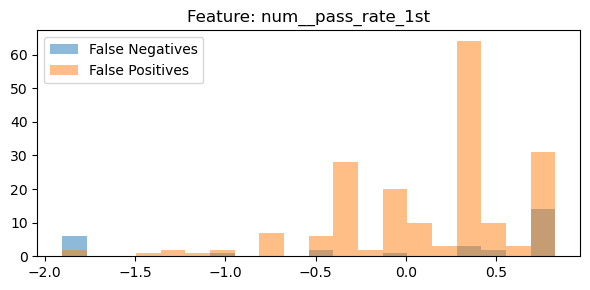

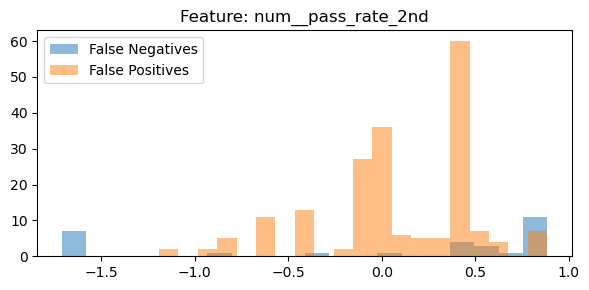

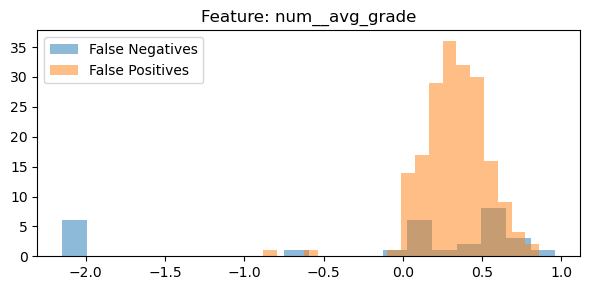

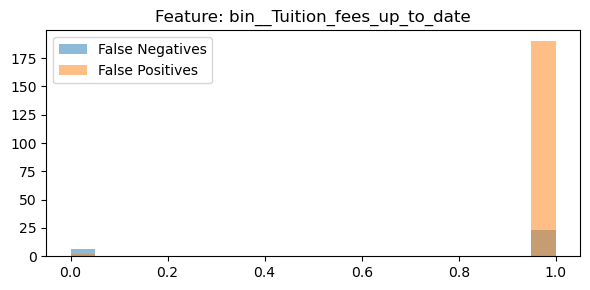

In [47]:
import matplotlib.pyplot as plt

features_to_plot = ['num__pass_rate_1st', 'num__pass_rate_2nd', 'num__avg_grade', 'bin__Tuition_fees_up_to_date']

for feat in features_to_plot:
    plt.figure(figsize=(6, 3))
    plt.hist(false_negatives[feat], bins=20, alpha=0.5, label='False Negatives')
    plt.hist(false_positives[feat], bins=20, alpha=0.5, label='False Positives')
    plt.title(f"Feature: {feat}")
    plt.legend()
    plt.tight_layout()
    plt.show()


| Feature                   | Motivo di errore                                                                   |
| ------------------------- | ---------------------------------------------------------------------------------- |
| `pass_rate` e `avg_grade` | il modello **esclude studenti con performance troppo basse**, anche se Enrolled    |
| `tuition_fees_up_to_date` | il modello **assume che chi paga le tasse sia ancora iscritto**, portando a FP     |
| `avg_grade`               | i voti intermedi **confondono il modello**, perché ambigui tra Enrolled e Graduate |


In [53]:

# Scegli un indice da uno dei due gruppi
false_negatives_idx = false_negatives.index[0]  # Enrolled classificato come altro
false_positives_idx = false_positives.index[0]  # Non-Enrolled classificato come Enrolled


# Esempio con un falso negativo
shap.initjs()
shap.plots.force(shap_values[false_positives_idx,:,1])


c:\Users\Martina\anaconda3\envs\DMML\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\Martina\anaconda3\envs\DMML\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 5, 6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


              precision    recall  f1-score   support

           0       0.81      0.74      0.77       355
           1       0.51      0.50      0.51       199
           2       0.83      0.88      0.86       552

    accuracy                           0.77      1106
   macro avg       0.72      0.71      0.71      1106
weighted avg       0.77      0.77      0.77      1106



Text(120.72222222222221, 0.5, 'True')

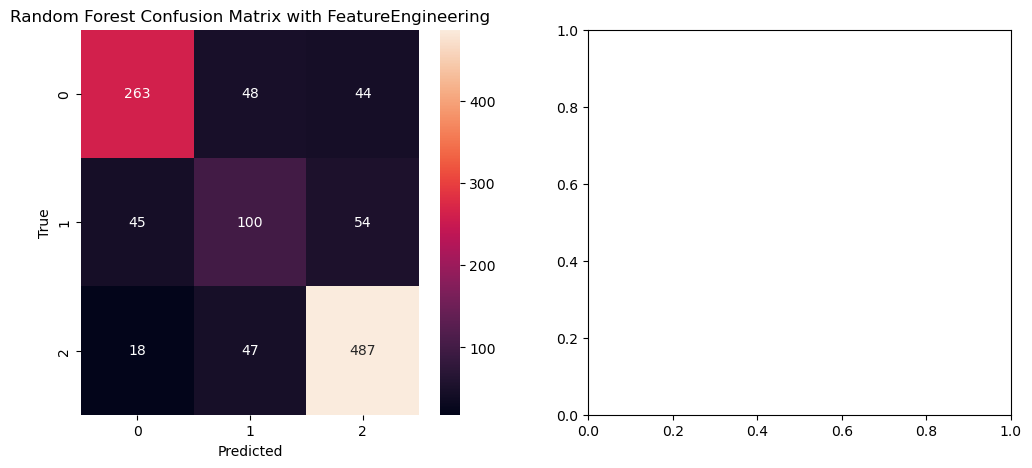

In [8]:
from imblearn.pipeline import Pipeline  
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import  confusion_matrix

from FeaturesTrasformer import FeaturesTransformer
from preprocessor import preprocessor

rf_pipeline = Pipeline(steps=[
    ('feature_transformer', FeaturesTransformer(drop_originals=True)),      
    ('preprocessor', preprocessor),              
    ('smote', SMOTE(random_state=42)),
    ('model', RandomForestClassifier(n_estimators=300, class_weight="balanced", random_state=42))
])

rf_pipeline.fit(X_train, y_train)

from sklearn.metrics import classification_report

y_pred = rf_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

fig, axes = plt.subplots(1,2, figsize=(12, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', ax=axes[0])
axes[0].set_title('Random Forest Confusion Matrix with FeatureEngineering')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')



c:\Users\Martina\anaconda3\envs\DMML\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 5, 6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


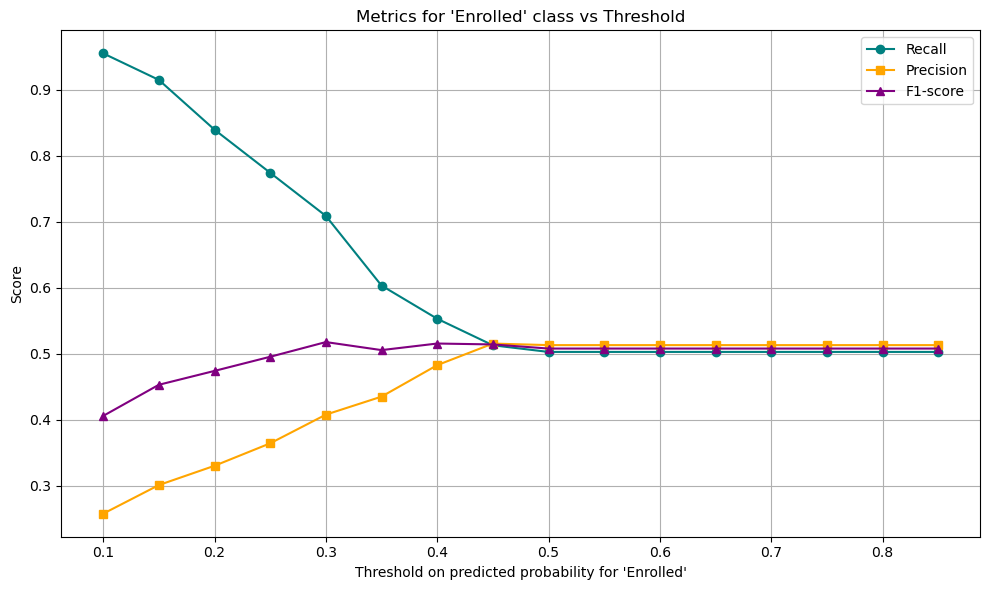

In [11]:

from sklearn.metrics import recall_score, precision_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

# Ottieni le probabilità (shape: n_samples x 3 classi)
y_proba = rf_pipeline.predict_proba(X_test)
# Inizializza le metriche
thresholds = np.arange(0.1, 0.9, 0.05)
recalls = []
precisions = []
f1s = []

for t in thresholds:
    y_pred_custom = []
    for prob in y_proba:
        if prob[1] > t:
            y_pred_custom.append(1)  # Forza "Enrolled"
        else:
            y_pred_custom.append(np.argmax(prob))  # Fallback

    # Calcolo metriche solo per la classe 'Enrolled' (label 1)
    recalls.append(recall_score(y_test, y_pred_custom, labels=[1], average='macro'))
    precisions.append(precision_score(y_test, y_pred_custom, labels=[1], average='macro', zero_division=0))
    f1s.append(f1_score(y_test, y_pred_custom, labels=[1], average='macro'))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, recalls, marker='o', label='Recall', color='teal')
plt.plot(thresholds, precisions, marker='s', label='Precision', color='orange')
plt.plot(thresholds, f1s, marker='^', label='F1-score', color='purple')
plt.title("Metrics for 'Enrolled' class vs Threshold")
plt.xlabel("Threshold on predicted probability for 'Enrolled'")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Se il tuo obiettivo è massimizzare il bilanciamento tra recall e precision sulla classe Enrolled, il punto migliore è:

🎯 Threshold ottimale ≈ 0.30–0.35
Con questo:

classifichi più studenti come Enrolled correttamente

accetti qualche falso positivo in cambio di meno falsi negativi

c:\Users\Martina\anaconda3\envs\DMML\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 5, 6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


              precision    recall  f1-score   support

           0       0.82      0.67      0.74       355
           1       0.43      0.60      0.51       199
           2       0.85      0.83      0.84       552

    accuracy                           0.74      1106
   macro avg       0.70      0.70      0.69      1106
weighted avg       0.77      0.74      0.75      1106



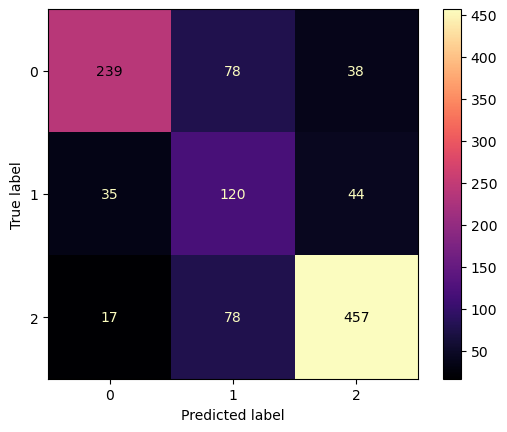

In [12]:
# 1. Calcola le probabilità con il tuo modello già allenato
y_proba = rf_pipeline.predict_proba(X_test)

# 2. Applica il threshold personalizzato (0.35 per 'Enrolled')
y_pred_threshold = []

for prob in y_proba:
    if prob[1] > 0.35:
        y_pred_threshold.append(1)  # Enrolled
    else:
        y_pred_threshold.append(np.argmax(prob))  # fallback: predizione standard

# 3. Valuta le performance
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print(classification_report(y_test, y_pred_threshold))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_threshold)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="magma")


Vorrei codice notebook per fare Model comparison tra Decision Tree, Random Forest, Support Vector Machine, Gradient Boosting, Extreme Gradient Boosting, CatBoost, and LightGBM. è Classificazione multi-label con classi sbilanciate, come metrica per il confronto usare F1-score, per ogni modello salvare anche balanced_accuracy, AUC ed F1-score di ogni classe. Inoltre deve essere fatto HyperParameter Tuning per ogni modello usando HalvingGridSearch. Usare StratifyKfold per la ricerca degli iperparametri e per valutare le performance del modello trovato internamente. Al termine salvare su disco il miglior modello. 
Il codice deve essere modulare e semplice, i dati sono gia stati splittati in test e train, deve avere una pipeline come segue:
('feature_transformer', FeaturesTransformer(drop_originals=True)),
('preprocessing', preprocessor),
('smote', SMOTE(random_state=42)),
('model', model)


# Model Comparison

In [7]:
#  Model Comparison for Multi-Class Imbalanced Classification
# ============================================
# Imports
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, balanced_accuracy_score, roc_auc_score, classification_report
import joblib
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier)
from sklearn.svm import SVC

from FeaturesTrasformer import FeaturesTransformer
from preprocessor import preprocessor

# Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Models and refined hyperparameter grids
def get_estimators_and_grids():
    estimators = {
        'decision_tree': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
        'random_forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
        'svm': SVC(probability=True, random_state=42),
        'gradient_boosting': GradientBoostingClassifier(random_state=42),
        'xgboost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        'lightgbm': LGBMClassifier(random_state=42),
        'catboost': CatBoostClassifier(verbose=0, random_state=42, allow_writing_files=False)
    }

    param_grids = {
        'decision_tree': {
            'model__max_depth': [None, 5, 10, 15],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4]
        },
        'random_forest': {
            'model__n_estimators': [100, 200, 300],
            'model__max_depth': [None, 10, 20],
            'model__max_features': ['sqrt', 'log2']
        },
        'svm': {
            'model__C': [0.1, 1, 10],
            'model__kernel': ['linear', 'rbf'],
            'model__gamma': ['scale', 'auto']
        },
        'gradient_boosting': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.01, 0.1],
            'model__max_depth': [3, 5]
        },
        'xgboost': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.01, 0.1],
            'model__max_depth': [3, 5],
            'model__subsample': [0.8, 1]
        },
        'lightgbm': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.01, 0.1],
            'model__num_leaves': [31, 50],
            'model__max_depth': [-1, 5]
        },
        'catboost': {
            'model__iterations': [100, 200],
            'model__learning_rate': [0.01, 0.1],
            'model__depth': [6, 10]
        }
    }
    return estimators, param_grids

# Build the imbalanced-learn pipeline
def build_pipeline(model):
    steps = [
        ('feature_transformer', FeaturesTransformer(drop_originals=True)),
        ('preprocessing', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ]
    return ImbPipeline(steps)

# Tuning, evaluation, and saving function
def tune_and_evaluate(name, estimator, param_grid):
    print(f"Tuning {name}...")
    pipeline = build_pipeline(estimator)
    search = HalvingGridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=cv,
        scoring='f1_macro',
        factor=2,
        random_state=42,
        verbose=0,
        n_jobs=-1
    )
    search.fit(X_train, y_train)
    best = search.best_estimator_
    print(f"Best params for {name}: {search.best_params_}")

    # Evaluate on test set
    y_pred = best.predict(X_test)
    y_prob = best.predict_proba(X_test)

    metrics = {
        'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
        'f1_macro': f1_score(y_test, y_pred, average='macro'),
        'roc_auc_macro': roc_auc_score(pd.get_dummies(y_test), y_prob, average='macro')
    }
    report = classification_report(y_test, y_pred, output_dict=True)
    per_class_f1 = {cls: report[cls]['f1-score'] for cls in report if cls not in ['accuracy', 'macro avg', 'weighted avg']}
    metrics['per_class_f1'] = per_class_f1

    # Save best model
    joblib.dump(best, f"../models/best_model_{name}.joblib")
    print(f"Saved best_model_{name}.joblib")

    return metrics, best



In [8]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

estimators, grids = get_estimators_and_grids()
results = {}
for name, estimator in estimators.items():
    metrics, _ = tune_and_evaluate(name, estimator, grids[name])
    results[name] = metrics

# Compile and save results
results_df = pd.DataFrame(results).T
print(results_df)
results_df.to_csv('../result/model_comparison_results.csv')

Tuning decision_tree...
Best params for decision_tree: {'model__max_depth': 5, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2}
Saved best_model_decision_tree.joblib
Tuning random_forest...
Best params for random_forest: {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__n_estimators': 300}
Saved best_model_random_forest.joblib
Tuning svm...
Best params for svm: {'model__C': 0.1, 'model__gamma': 'scale', 'model__kernel': 'linear'}
Saved best_model_svm.joblib
Tuning gradient_boosting...
Best params for gradient_boosting: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}
Saved best_model_gradient_boosting.joblib
Tuning xgboost...
Best params for xgboost: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__subsample': 0.8}
Saved best_model_xgboost.joblib
Tuning lightgbm...


  File "c:\Users\Martina\anaconda3\envs\DMML\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10513
[LightGBM] [Info] Number of data points in the train set: 5301, number of used features: 112
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

Random Forest ha il miglior F1-macro e ROC AUC macro

LightGBM ha la miglior balanced accuracy e buoni valori anche sulle altre metriche

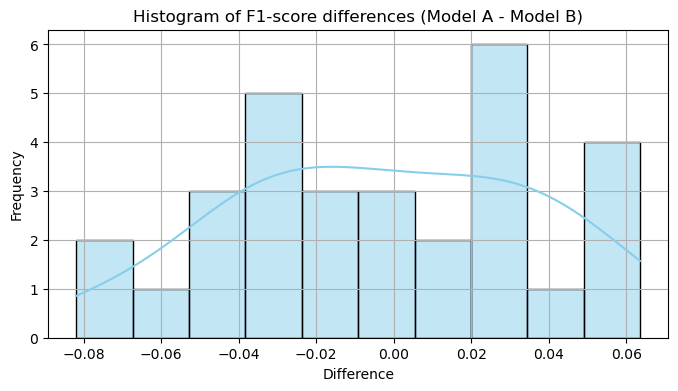

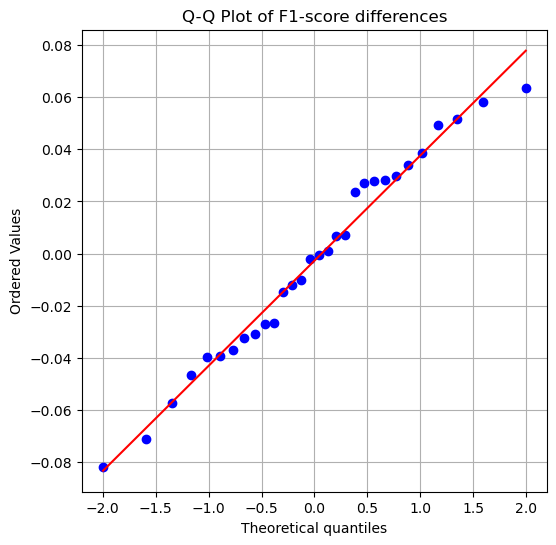

In [ ]:
import numpy as np
import joblib
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from scipy.stats import shapiro, ttest_rel, wilcoxon
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import RepeatedStratifiedKFold


# === Carica i modelli salvati ===
model_a = joblib.load("../models/best_model_lightgbm.joblib")
model_b = joblib.load("../models/best_model_random_forest.joblib")


# === Cross-validation manuale per confronto ===
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

f1_scores_a = []
f1_scores_b = []

for train_idx, test_idx in cv.split(X_test, y_test):
    X_fold = X_test.iloc[test_idx]
    y_fold = y_test.iloc[test_idx]


    y_pred_a = model_a.predict(X_fold)
    y_pred_b = model_b.predict(X_fold)

    f1_scores_a.append(f1_score(y_fold, y_pred_a, average='macro'))
    f1_scores_b.append(f1_score(y_fold, y_pred_b, average='macro'))

f1_scores_a = np.array(f1_scores_a)
f1_scores_b = np.array(f1_scores_b)

# === Differenze per test statistici ===
diff = f1_scores_a - f1_scores_b


# === Istogramma delle differenze ===
plt.figure(figsize=(8, 4))
sns.histplot(diff, kde=True, bins=10, color='skyblue')
plt.title("Histogram of F1-score differences (Model A - Model B)")
plt.xlabel("Difference")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# === Q-Q plot ===
plt.figure(figsize=(6, 6))
stats.probplot(diff, dist="norm", plot=plt)
plt.title("Q-Q Plot of F1-score differences")
plt.grid(True)
plt.show()




In [16]:
from scipy.stats import wilcoxon

w_p_value = wilcoxon(diff)
print('Wilcoxon signed-rank test p-value:', w_p_value)

Wilcoxon signed-rank test p-value: WilcoxonResult(statistic=216.0, pvalue=0.7456546742469072)


Non ci sono differenze significative tra i due modelli

# Performance evaluation

In [19]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay
import numpy as np


# ==============================
# Confusion Matrix
# ==============================
def confusion_matrix_plot(y_true, y_pred, classes, name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


# ==============================
# ROC Curve (One-vs-Rest)
# ==============================
def roc_curve_plot(y_true, y_prob, classes, name):

    y_true_bin = label_binarize(y_true, classes=classes)
    n_classes = y_true_bin.shape[1]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Traccia le curve ROC per ogni classe
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - One-vs-Rest ({name})")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()




=== Classification Report: LightGBM ===
              precision    recall  f1-score   support

           0     0.8292    0.7007    0.7595       284
           1     0.4515    0.5849    0.5096       159
           2     0.8474    0.8416    0.8445       442

    accuracy                         0.7503       885
   macro avg     0.7093    0.7091    0.7045       885
weighted avg     0.7704    0.7503    0.7571       885



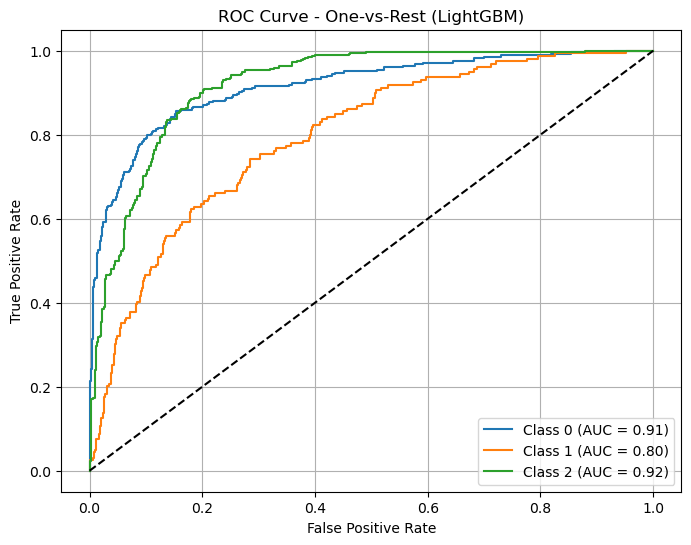

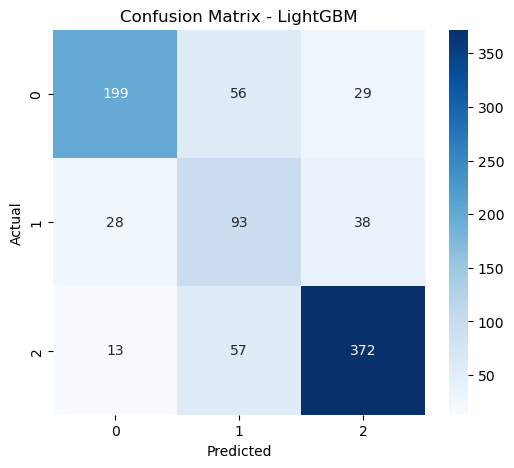

In [22]:
# Ricarica il modello salvato
model = joblib.load("../models/best_model_lightgbm.joblib")  # Cambia il nome se necessario

# Predizioni
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)

# Classification report per ciascun modello
print("=== Classification Report: LightGBM ===")
print(classification_report(y_test, y_pred, digits=4))


# Plot ROC Curve
roc_curve_plot(y_test, y_prob, model.classes_, "LightGBM")
confusion_matrix_plot(y_test, y_pred, model.classes_, "LightGBM")


=== Classification Report: Random Forest ===
              precision    recall  f1-score   support

           0     0.8282    0.7641    0.7949       284
           1     0.4934    0.4717    0.4823       159
           2     0.8217    0.8756    0.8478       442

    accuracy                         0.7672       885
   macro avg     0.7144    0.7038    0.7083       885
weighted avg     0.7648    0.7672    0.7651       885



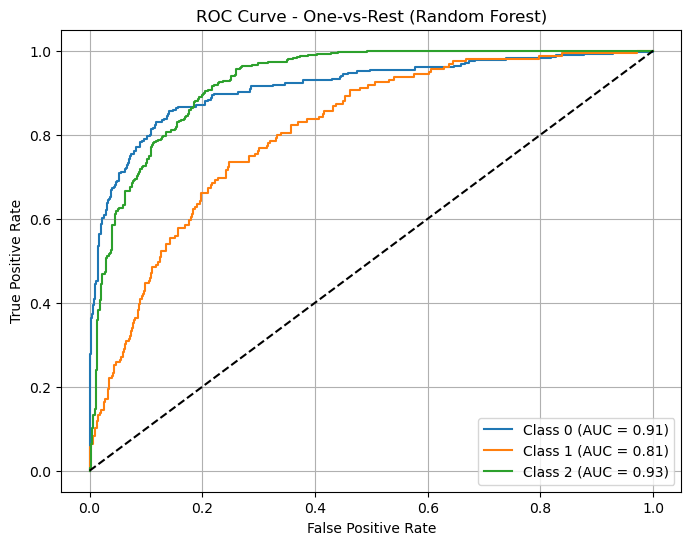

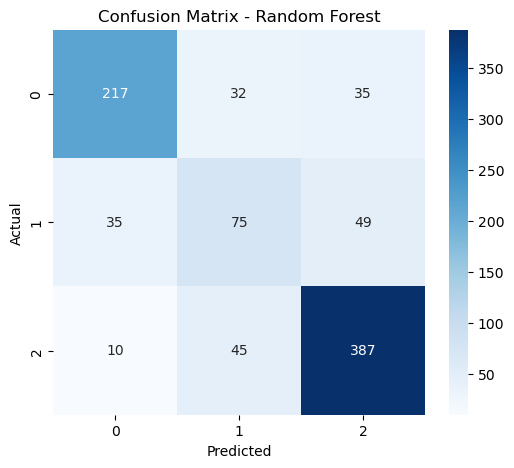

In [23]:
# Ricarica il modello salvato
model = joblib.load("../models/best_model_random_forest.joblib")  # Cambia il nome se necessario

# Predizioni
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)


print("\n=== Classification Report: Random Forest ===")
print(classification_report(y_test, y_pred, digits=4))

# Plot ROC Curve
roc_curve_plot(y_test, y_prob, model.classes_, "Random Forest")
confusion_matrix_plot(y_test, y_pred, model.classes_, "Random Forest")

# SHAP

In [54]:
import joblib
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Carica modello salvato (pipeline completa)
pipeline = joblib.load("../models/best_model_random_forest.joblib")

# Prepara X_test trasformato fino allo step 'model'
X_test_fe = pipeline.named_steps['feature_transformer'].transform(X_test)
X_test_proc = pipeline.named_steps['preprocessing'].transform(X_test_fe)

# Rendi array denso se necessario
if hasattr(X_test_proc, "toarray"):
    X_test_proc = X_test_proc.toarray()

# Recupera i nomi delle feature dopo il preprocessing
feature_names = pipeline.named_steps['preprocessing'].get_feature_names_out()

# Ricrea DataFrame con nomi feature
X_shap = pd.DataFrame(X_test_proc, columns=feature_names)

# Estrai il modello finale (es. Random Forest, LightGBM, ecc.)
model = pipeline.named_steps['model']

# Usa TreeExplainer per modelli tree-based
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_shap)

# Salva tutto (tutte le classi)
joblib.dump(shap_values, "../shap_output/shap_values_all_classes.joblib")
joblib.dump(explainer, "../shap_output/shap_explainer.joblib")
X_shap.to_csv("../shap_output/X_shap.csv", index=False)
np.save("../shap_output/feature_names.npy", feature_names)




🔍 SHAP grouped bar plot for class 0


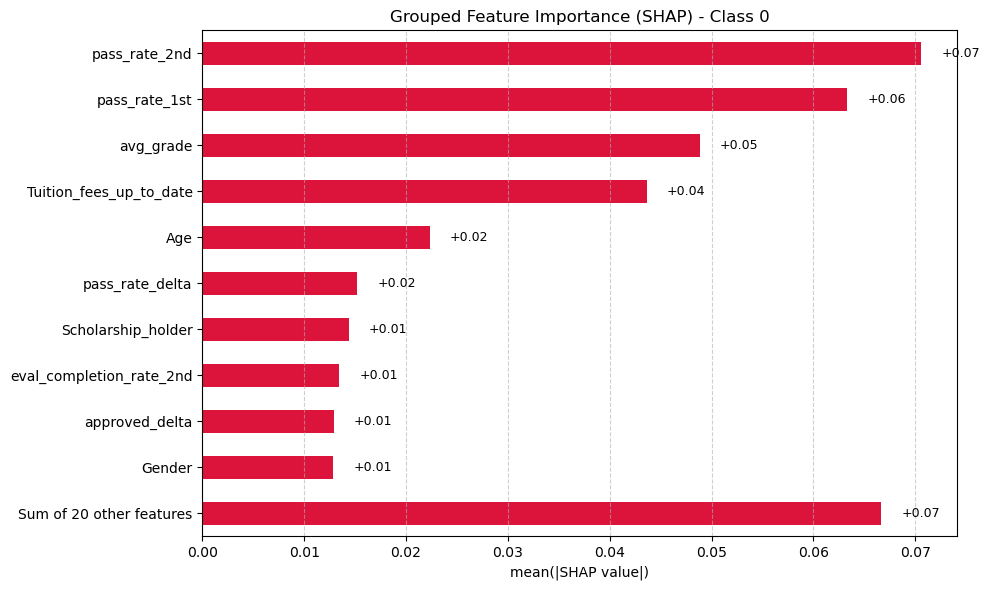


🔍 SHAP grouped bar plot for class 1


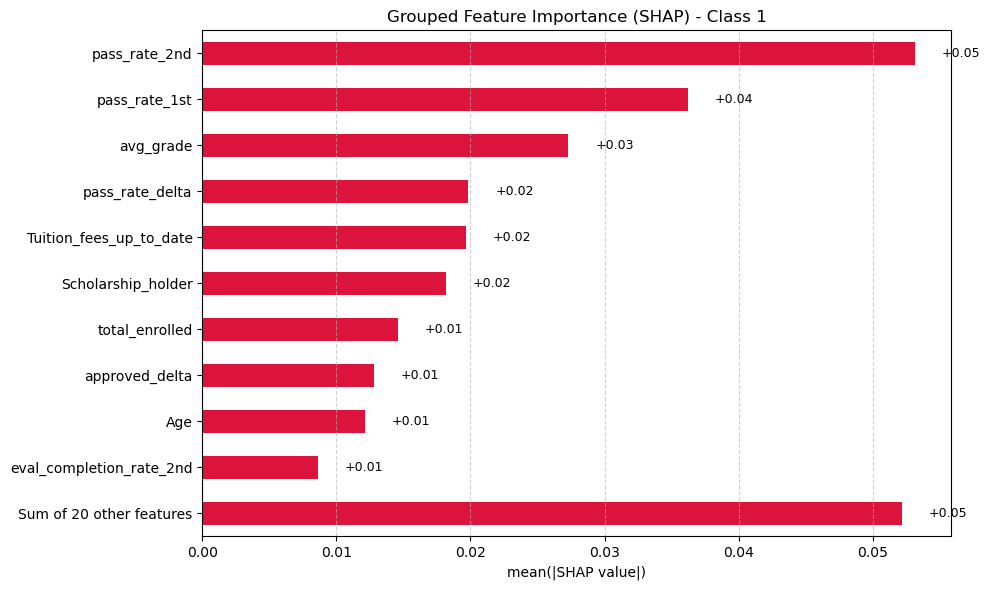


🔍 SHAP grouped bar plot for class 2


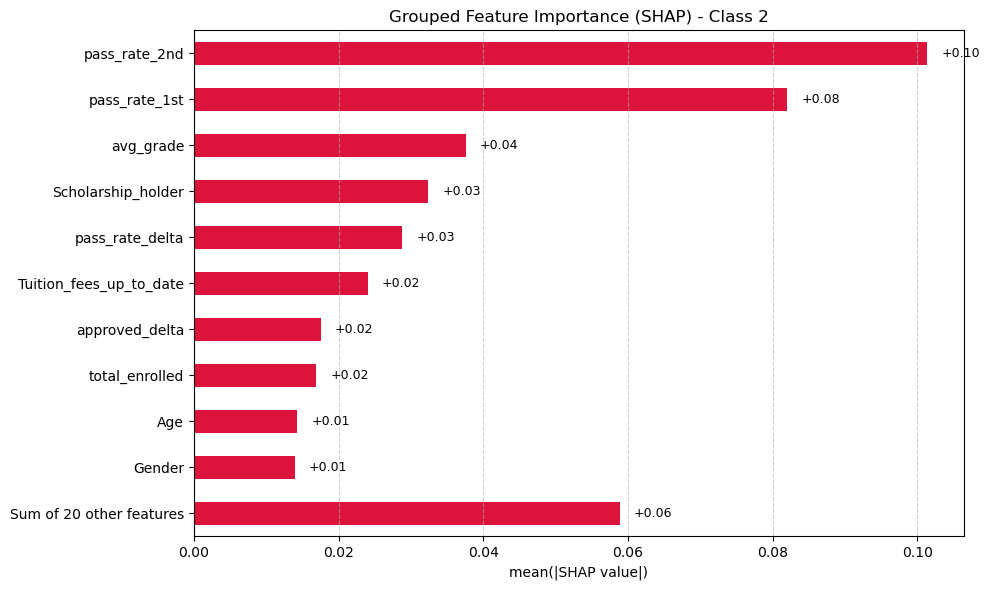

In [46]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

# Funzione di raggruppamento migliorata
def get_group_name(col):
    if col.startswith("oh__"):
        match = re.match(r"oh__([A-Za-z0-9_]+?)_\d+$", col)
        if match:
            return match.group(1)
        else:
            return col.replace("oh__", "")
    elif "__" in col:
        return col.split("__")[1]
    else:
        return col

# Per ogni classe
for i, class_name in enumerate(pipeline.classes_):
    print(f"\n🔍 SHAP grouped bar plot for class {class_name}")

    # Step 1: SHAP per quella classe
    shap_vals = shap_values[:, :, i]
    shap_df = pd.DataFrame(np.abs(shap_vals), columns=feature_names)

    # Step 2: Rinomina colonne con nomi raggruppati
    grouped_names = [get_group_name(col) for col in shap_df.columns]
    shap_df.columns = grouped_names

    # Step 3: Raggruppa e media
    shap_grouped = shap_df.groupby(shap_df.columns, axis=1).mean()
    shap_importance = shap_grouped.mean().sort_values(ascending=False)

    # Step 4: Top N + somma altre
    top_n = 10
    top_shap = shap_importance[:top_n]
    other_sum = shap_importance[top_n:].sum()
    top_shap[f"Sum of {len(shap_importance) - top_n} other features"] = other_sum

    # Step 5: Plot
    plt.figure(figsize=(10, 6))
    top_shap[::-1].plot(kind='barh', color='crimson')
    for j, v in enumerate(top_shap[::-1]):
        plt.text(v + 0.002, j, f"+{v:.2f}", va='center', fontsize=9)
    plt.xlabel("mean(|SHAP value|)")
    plt.title(f"Grouped Feature Importance (SHAP) - Class {class_name}")
    plt.grid(True, axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


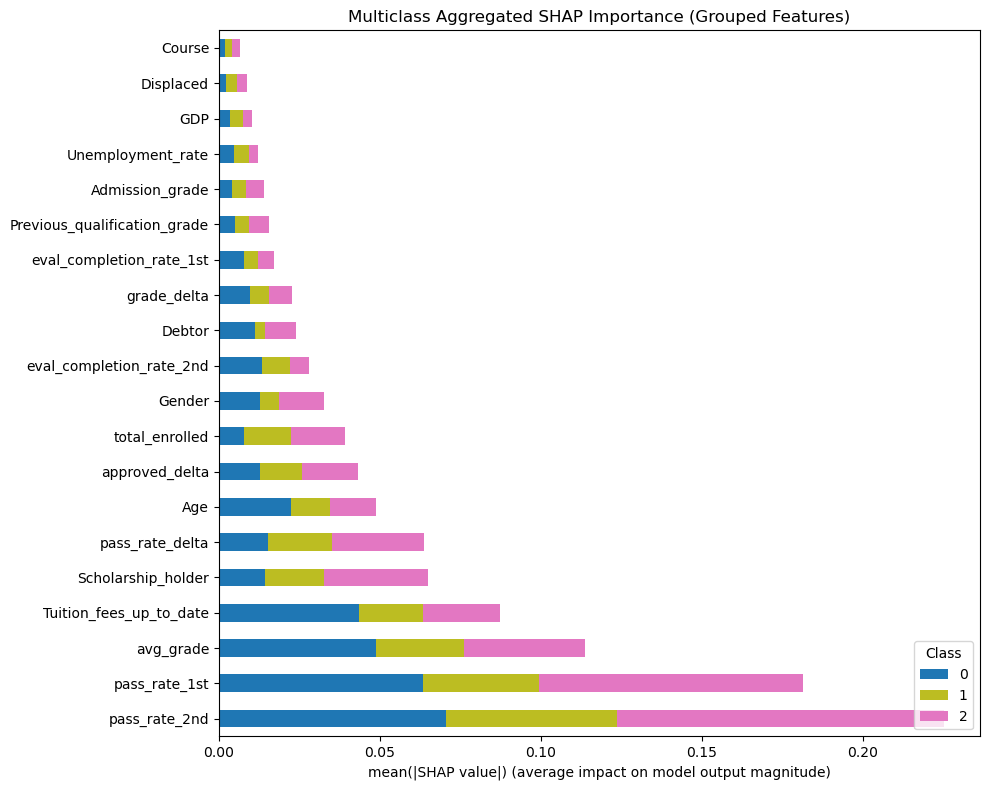

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

# === Funzione per raggruppare correttamente i nomi delle feature OHE
def get_group_name(col):
    if col.startswith("oh__"):
        match = re.match(r"oh__([A-Za-z0-9_]+?)_\d+$", col)
        if match:
            return match.group(1)
        else:
            return col.replace("oh__", "")
    elif "__" in col:
        return col.split("__")[1]
    else:
        return col

# === Aggrega SHAP per classe e raggruppa le feature OHE
class_names = pipeline.classes_
n_classes = len(class_names)

aggregated_shap_class_df = []

for i in range(n_classes):
    # SHAP per la classe i
    shap_vals = shap_values[:, :, i]  # shape: (n_samples, n_features)
    shap_df = pd.DataFrame(np.abs(shap_vals), columns=feature_names)

    # Rinomina le colonne con nome raggruppato
    grouped_names = [get_group_name(col) for col in shap_df.columns]
    shap_df.columns = grouped_names

    # Raggruppa e calcola la media assoluta per ogni gruppo
    shap_grouped = shap_df.groupby(shap_df.columns, axis=1).mean()
    shap_importance = shap_grouped.mean().rename(class_names[i])

    aggregated_shap_class_df.append(shap_importance)

# === Unione delle importanze per tutte le classi
shap_importance_df = pd.concat(aggregated_shap_class_df, axis=1).fillna(0)

# === Seleziona le feature più importanti in media
top_features = shap_importance_df.mean(axis=1).sort_values(ascending=False).head(20).index
shap_top = shap_importance_df.loc[top_features]

# === Plot stile stacked bar (colore per classe)
shap_top.plot(kind="barh", stacked=True, figsize=(10, 8), color=["#1f77b4", "#bcbd22", "#e377c2"])  # blu, verde, rosa
plt.xlabel("mean(|SHAP value|) (average impact on model output magnitude)")
plt.title("Multiclass Aggregated SHAP Importance (Grouped Features)")
plt.legend(title="Class", loc="lower right")
plt.tight_layout()
plt.show()


In [53]:
import shap
import matplotlib.pyplot as plt

# Se stai usando notebook, abilita la visualizzazione JS
shap.initjs()

# === Scegli l'indice dello studente (es. primo = 0)
student_index = 30

# === Applica la pipeline fino al preprocessing
X_student_fe  = pipeline.named_steps['feature_transformer'].transform(X_test.iloc[[student_index]])
X_student_proc = pipeline.named_steps['preprocessing'].transform(X_student_fe)

# Rendi denso se necessario
if hasattr(X_student_proc, "toarray"):
    X_student_proc = X_student_proc.toarray()

# Feature names dopo preprocessing
feature_names = pipeline.named_steps['preprocessing'].get_feature_names_out()
X_shap_student = pd.DataFrame(X_student_proc, columns=feature_names)

# === Estrai il modello
model = pipeline.named_steps['model']

# === Usa TreeExplainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_shap_student)

# === Force plot per la classe 0 (Dropout)
shap.force_plot(
    base_value=explainer.expected_value[0], 
    shap_values=shap_values[:,:,0], 
    features=X_shap_student,
    feature_names=feature_names
)
